In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from models import MLP
from data import get_data_classif

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import numpy as np
from curvlinops import HessianLinearOperator
from torch.distributions.multivariate_normal import _precision_to_scale_tril
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from copy import deepcopy

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
DIMENSIONS = [2, 16, 16]
LR = 0.5
WD = 0.001
EPOCHS = 500

# generate data
X_train, y_train = make_moons(n_samples=100, noise=0.1, random_state=0)
# mean(y_train) => half of the points are 0, half are 1

GRID_SIZE = 100
x1, x2 = np.meshgrid(
    np.linspace(-4.5, 4.5, GRID_SIZE),
    np.linspace(-4.5, 4.5, GRID_SIZE)
)
X_test = np.c_[x1.ravel(), x2.ravel()]

cmap = plt.get_cmap('coolwarm')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
color0 = sm.cmap(0)
color1 = sm.cmap(1)

In [6]:
def plot_moons(ax, pred_prob, plot_lines=True, pointsize=5, levels=10):
    if torch.is_tensor(pred_prob):
        pred_prob = pred_prob.cpu().detach().numpy()
    pred_prob = pred_prob.reshape(GRID_SIZE, GRID_SIZE)

    ax.set_xlim(-4.5, 4.5)
    ax.set_xlim(-4.5, 4.5)
    ax.contourf(
        x1, x2, pred_prob,
        alpha=0.65, levels=levels, cmap=sm.cmap, antialiased=True,
        vmin=0, vmax=1
    )
    if plot_lines:
        ax.contour(
            x1, x2, pred_prob,
            alpha=0.3, levels=levels, cmap=sm.cmap, antialiased=True,
            vmin=0, vmax=1, linewidths=0.3
        )
    ax.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train,
        cmap=sm.cmap, alpha=0.8, s=pointsize, zorder = 10
    )

### Laplace Approximation

In [38]:
torch.manual_seed(0)
train_loader = DataLoader(
    TensorDataset(
        torch.as_tensor(X_train, dtype=torch.float32, device=device),
        torch.as_tensor(y_train, dtype=torch.float32, device=device).unsqueeze(1)
      ),
    batch_size=64, shuffle=True
)
# train single net
net = MLP(*DIMENSIONS, output_type="binary", dropout_rate=0.0)
net.train(
    train_loader, n_epochs=EPOCHS, lr=LR, weight_decay=WD,
    milestones=[2000], gamma=1, # no learning rate decay
    seed=1, log_interval=100
)

Epoch 100/500, Training Loss: 0.040874, Accuracy: 0.990000
Epoch 200/500, Training Loss: 0.010007, Accuracy: 1.000000
Epoch 300/500, Training Loss: 0.007733, Accuracy: 1.000000
Epoch 400/500, Training Loss: 0.007816, Accuracy: 1.000000
Epoch 500/500, Training Loss: 0.006095, Accuracy: 1.000000


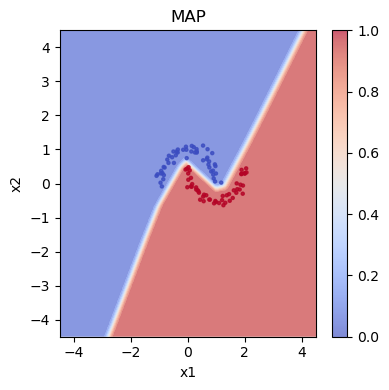

In [39]:
# visualize data and single net output
fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="tight")
plot_moons(ax, net.predict(X_test))
ax.set_title("MAP")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.colorbar(sm, ax=ax, alpha=0.65)
plt.savefig("../thesis/images/classif_map.pdf")

100%|██████████| 1000/1000 [00:00<00:00, 2172.29it/s]


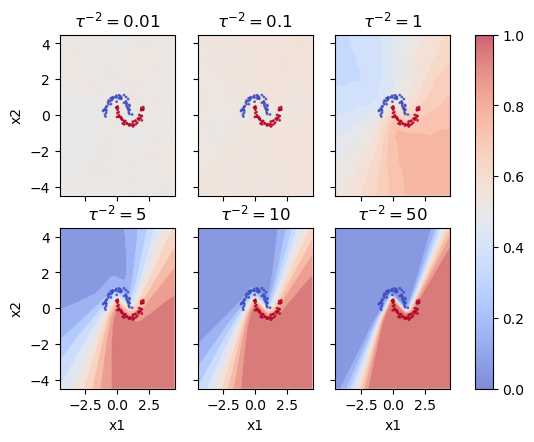

In [40]:
# compute Hessian
la_net = deepcopy(net)
params = [p for p in la_net.model.parameters() if p.requires_grad]
hessian_nll = HessianLinearOperator(
    model_func=la_net.model,
    loss_func=nn.BCEWithLogitsLoss(),
    params=params,
    data=train_loader,
    progressbar=True
)
identity = np.eye(hessian_nll.shape[0], dtype=np.float32)
hessian_nll = torch.as_tensor(
    hessian_nll @ identity,
    dtype=torch.float32, device=device
)

# plot different prior precision settings
fig, ax = plt.subplots(2, 3, sharex="all", sharey="all", figsize=(6.3, 4.6))
prior_precision = [0.01, 0.1, 1, 5, 10, 50]
la_preds = []
for j, prec in enumerate(prior_precision):
    post_precision = hessian_nll + prec * torch.eye(hessian_nll.shape[0], dtype=torch.float32).to(device)

    post_scale = _precision_to_scale_tril(post_precision)
    post_mean = parameters_to_vector(net.model.parameters())

    torch.manual_seed(0)
    n_samples = 1000
    n_params = post_mean.shape[0]
    z = torch.randn(n_samples * n_params , dtype=torch.float32, device=device)
    z = z.reshape(n_samples, n_params)
    samples = z @ post_scale + post_mean.reshape(1, n_params)

    # compute predictive
    preds = []
    for i in tqdm(range(n_samples)):
        param_vec = samples[i, :]
        # update params in-place
        vector_to_parameters(param_vec, params)
        pred = la_net.predict(X_test)
        preds.append(pred)

    preds = np.stack(preds, axis=0).mean(axis=0).reshape(GRID_SIZE, GRID_SIZE)
    la_preds.append(preds)
    plot_moons(ax[j // 3, j % 3], preds, pointsize=1)
    ax[j // 3, j % 3].set_title(r'$\tau^{-2} =$' + str(prec))
ax[0, 0].set_ylabel("x2")
ax[1, 0].set_ylabel("x2")
ax[1, 0].set_xlabel("x1")
ax[1, 1].set_xlabel("x1")
ax[1, 2].set_xlabel("x1")
fig.colorbar(sm, ax=ax, alpha=0.65)
plt.savefig("../thesis/images/classif_laplace.pdf")

### Deep Ensemble

In [35]:
ensemble_size = 10
ensemble = []
for i in range(ensemble_size):
    print("===========")
    print(f"Training model {i}")
    torch.manual_seed(i)
    train_loader = DataLoader(
        TensorDataset(
            torch.as_tensor(X_train, dtype=torch.float32, device=device),
            torch.as_tensor(y_train, dtype=torch.float32, device=device).unsqueeze(1)
        ),
        batch_size=64, shuffle=True
    )
    net = MLP(*DIMENSIONS, output_type="binary", dropout_rate=0.0)
    net.train(
        train_loader, n_epochs=EPOCHS, lr=LR, weight_decay=WD,
        milestones=[2000], gamma=1, # no learning rate decay
        seed=i+114, log_interval=100
    )
    ensemble.append(net)

Training model 0
Epoch 100/500, Training Loss: 0.028898, Accuracy: 1.000000
Epoch 200/500, Training Loss: 0.009965, Accuracy: 1.000000
Epoch 300/500, Training Loss: 0.007322, Accuracy: 1.000000
Epoch 400/500, Training Loss: 0.006782, Accuracy: 1.000000
Epoch 500/500, Training Loss: 0.006234, Accuracy: 1.000000
Training model 1
Epoch 100/500, Training Loss: 0.031024, Accuracy: 0.990000
Epoch 200/500, Training Loss: 0.008682, Accuracy: 1.000000
Epoch 300/500, Training Loss: 0.005829, Accuracy: 1.000000
Epoch 400/500, Training Loss: 0.005374, Accuracy: 1.000000
Epoch 500/500, Training Loss: 0.005046, Accuracy: 1.000000
Training model 2
Epoch 100/500, Training Loss: 0.053293, Accuracy: 0.990000
Epoch 200/500, Training Loss: 0.013240, Accuracy: 1.000000
Epoch 300/500, Training Loss: 0.009042, Accuracy: 1.000000
Epoch 400/500, Training Loss: 0.006829, Accuracy: 1.000000
Epoch 500/500, Training Loss: 0.006301, Accuracy: 1.000000
Training model 3
Epoch 100/500, Training Loss: 0.021020, Accurac

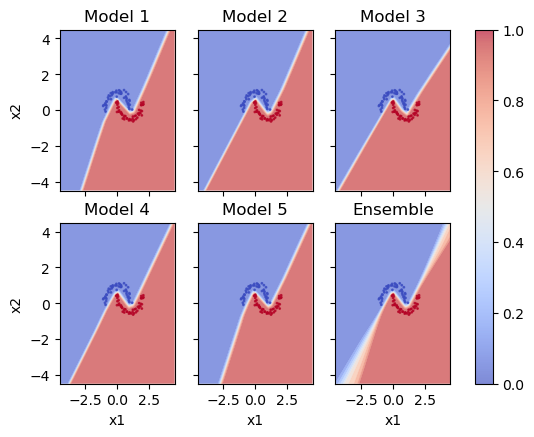

In [36]:
# plot 5 models and ensemble prediction
fig, ax = plt.subplots(2, 3, figsize=(6.3, 4.6), sharex="all", sharey="all")

ensemble_pred_probs = []
for i, net in enumerate(ensemble):
    pred_prob = net.predict(X_test)
    ensemble_pred_probs.append(pred_prob)
    if i < 5:
        plot_moons(ax[i // 3, i % 3], pred_prob, pointsize=1)
        ax[i // 3, i % 3].set_title(f"Model {i+1}")

ensemble_pred_prob = np.stack(ensemble_pred_probs, axis=0).mean(axis=0)
ensemble_pred_prob = ensemble_pred_prob.reshape(GRID_SIZE, GRID_SIZE)
plot_moons(ax[1, 2], ensemble_pred_prob, pointsize=1)
plt.title("Ensemble")
plt.colorbar(sm, ax=ax, alpha=0.65)
ax[0, 0].set_ylabel("x2")
ax[1, 0].set_ylabel("x2")
ax[1, 0].set_xlabel("x1")
ax[1, 1].set_xlabel("x1")
ax[1, 2].set_xlabel("x1")
plt.savefig("../thesis/images/classif_ensemble.pdf")

### MC Dropout

In [4]:
torch.manual_seed(0)
X_train, y_train = get_data_classif(n_samples=128, noise=0.1, seed=1)
train_loader = DataLoader(
    TensorDataset(
        torch.as_tensor(X_train, dtype=torch.float32, device=device),
        torch.as_tensor(y_train, dtype=torch.float32, device=device).unsqueeze(1)
    ),
    batch_size=64, shuffle=True
)
net = MLP(*DIMENSIONS, output_type="binary", dropout_rate=0.2)
net.train(
    train_loader, n_epochs=EPOCHS, lr=LR, weight_decay=WD,
    milestones=[2000], gamma=1, # no learning rate decay
    seed=1, log_interval=100
)

Epoch 100/500, Training Loss: 0.178423, Accuracy: 0.921875
Epoch 200/500, Training Loss: 0.145598, Accuracy: 0.937500
Epoch 300/500, Training Loss: 0.095028, Accuracy: 0.968750
Epoch 400/500, Training Loss: 0.040624, Accuracy: 1.000000
Epoch 500/500, Training Loss: 0.057836, Accuracy: 0.976562


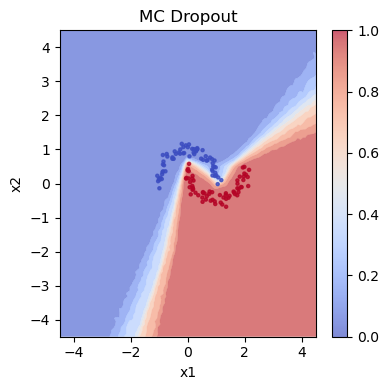

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="tight")

n_samples = 1000
torch.manual_seed(0)
preds = []
for i in range(n_samples):
    pred = net.predict(X_test, mc_dropout=True)
    preds.append(pred)

mean_pred = np.stack(preds, axis=0).mean(axis=0)

plot_moons(ax, mean_pred)
plt.title("MC Dropout")
plt.colorbar(sm, ax=ax, alpha=0.65)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.savefig("../thesis/images/classif_mc_dropout.pdf")